In [1]:
import numpy as np
import pandas as pd
from toolz import *
from toolz.curried import *
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC as _SVM
from sklearn.tree import DecisionTreeClassifier as _DT
from sklearn.neural_network import MLPClassifier as _NN
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [2]:
trainPath   = "./train.csv"
testPath    = "./test.csv"

# Load the dataset
train = pd.read_csv(trainPath)
test = pd.read_csv(testPath)

train = pd.read_csv(trainPath).assign(train = 1)
test  = pd.read_csv(testPath).assign(train = 0)

In [3]:
train.head(5)

,train,success,cet_oapr,english,reading,science,quantitative,abstract,shs_gpa,program,...,s20,s21,s22,s23,s24,s25,s26,s27,laptop,internet
0,1,0,76.98,66.01,54.75,80.93,84.63,83.75,86.13,BS Information Technology,...,Seldom,Often/Always,Often/Always,Often/Always,Seldom,Research online,More than 1 hour but less than 2 hours/day,Up to 30 minutes/day,Yes,Post-paid plan(Unlimited Data Subscription to ...
1,1,1,76.07,68.50,71.99,66.81,79.96,79.78,91.00,BS Computer Science,...,Sometimes,Sometimes,Sometimes,Sometimes,Sometimes,Ask my friends,More than 30 min. but less than 1 hour/day,More than 30 min. but less than 1 hour/day,Planning to purchase,Post-paid plan(Unlimited Data Subscription to ...
2,1,1,68.07,61.05,71.99,44.12,79.96,64.10,92.50,BS Computer Science,...,Seldom,Sometimes,Sometimes,Often/Always,Sometimes,Ask my friends,More than 1 hour but less than 2 hours/day,Up to 30 minutes/day,Planning to purchase,Post-paid plan(Unlimited Data Subscription to ...
3,1,0,83.50,88.66,71.99,76.79,63.45,63.10,86.74,BS Information Technology,...,Sometimes,Often/Always,Often/Always,Often/Always,Sometimes,Research online,I don’t study.,Up to 30 minutes/day,Yes,Post-paid plan(Unlimited Data Subscription to ...
4,1,1,60.09,61.05,25.06,59.25,70.61,72.90,88.50,BS Information Technology,...,Seldom,Sometimes,Often/Always,Often/Always,Often/Always,Research online,More than 1 hour but less than 2 hours/day,More than 2 hours but less than 3 hours/day,Yes,Pre-paid plan(Limited Data Subscription)


In [4]:
train.describe()

,train,success,cet_oapr,english,reading,science,quantitative,abstract,shs_gpa
count,290.0,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000
mean,1.0,0.517241,77.575485,75.951634,73.105062,68.514866,62.624316,69.866284,89.312250
std,0.0,0.500566,10.635311,13.467330,18.013840,19.553907,22.974370,20.777657,3.472975
min,1.0,0.000000,54.310000,34.940000,25.060000,3.340000,6.590000,4.240000,77.000000
25%,1.0,0.000000,70.300000,66.010000,61.110000,53.572500,44.180000,53.290000,87.000000
50%,1.0,1.000000,76.980000,76.830000,77.120000,72.660000,63.450000,72.900000,89.550000
75%,1.0,1.000000,85.397500,86.350000,87.400000,80.930000,79.960000,83.750000,92.000000
max,1.0,1.000000,99.860000,99.850000,99.770000,99.870000,99.340000,99.280000,97.000000


In [5]:
num_rows, num_columns = train.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 290
Number of columns: 90


In [6]:
data_types = train.dtypes
print(data_types)

train         int64
success       int64
cet_oapr    float64
english     float64
reading     float64
             ...   
s25          object
s26          object
s27          object
laptop       object
internet     object
Length: 90, dtype: object


In [7]:
class SVM:
    def __init__(self, kwargs):
        self.kwargs = kwargs

    def train(self, X, y):
        self.X = X
        self.fitted = _SVM(**self.kwargs).fit(X, y)

    def predict(self, X):
        return self.fitted.predict(X)

    def feature_importances(self):
        return dict(zip(self.X.columns, np.abs(self.fitted.coef_[0])))


class DT:
    def __init__(self, kwargs):
        self.kwargs = kwargs

    def train(self, X, y):
        self.X = X
        self.fitted = _DT(**self.kwargs).fit(X, y)

    def predict(self, X):
        return self.fitted.predict(X)

    def feature_importances(self):
        return dict(zip(self.X.columns, self.fitted.feature_importances_))


class NN:
    def __init__(self, kwargs):
        self.kwargs = kwargs

    def train(self, X, y):
        self.X = X
        self.fitted = _NN(**self.kwargs).fit(X, y)

    def predict(self, X):
        return self.fitted.predict(X)

    def feature_importances(self):
        # Feature importances not implemented for NN
        return dict(zip(self.X.columns, np.zeros(len(self.X.columns))))

In [8]:
class Models :
    
    def __init__(self, modelArgs):
                
        self.modelArgs = modelArgs 
        self.model = {"SVM"  : SVM  ,
                      "DT": DT,
                      "NN"  : NN}[self.modelArgs.modelName](self.modelArgs.kwargs)
        
    def train (self, X, y):
        print(f"training {self.modelArgs.modelName} ...")        
        self.model.train(X, y)
        print(f"done")
            
    def predict(self, X):
        print(f"predicting {self.modelArgs.modelName} ...")
        yHat = self.model.predict(X)
        print(f"done")
        return yHat

    def evaluate(self, X, y):
        y_pred = self.predict(X)

        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        auc = roc_auc_score(y, y_pred)

        plt.figure().set_figwidth(30)
        plt.plot(y_pred, "-b", label="predicted", alpha=0.3)
        plt.plot(y, "-r", label="true", alpha=0.3)
        plt.title(f"Model: ({self.modelArgs.modelName})\nAccuracy: {accuracy:.2f}, F1-score: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, AUC: {auc:.2f}")
        plt.xlabel("Observation")
        plt.ylabel("Class Label")
        plt.legend()
        plt.show()

        return accuracy, f1, precision, recall, auc

    
    def interpret(self):
        importances = self.model.feature_importances()
        importances = dict(sorted(importances.items(), key=lambda kv: kv[1], reverse = True))
        
        plt.figure().set_figwidth(30)
        plt.bar(importances.keys(),
                importances.values())
        plt.title(f"model:({self.modelArgs.__name__})" )        
        plt.xlabel("Features")
        plt.ylabel("Importance")
        plt.xticks(rotation=-45, ha="left")        
        plt.show()        
        return importances

In [9]:
def toOneHot(df, inputTypes):
    df = df[inputTypes.keys()]
    df.astype(inputTypes)
    for columnName, inputType in inputTypes.items():
        if inputType == str:
            oneHot = pd.get_dummies(df[columnName], prefix = columnName)            
            df = pd.concat([df,oneHot], axis=1).drop([columnName], axis=1)
    return df

In [10]:
class SVMArgs:
    modelName = "SVM"
    kwargs = {'kernel': 'linear'}     

class DTArgs:
    modelName = "DT"
    kwargs    = {}
    
class NNArgs:
    modelName = "NN"
    kwargs = {}

class Args :
    inputVars = {"success"               : float, # to predict
                 
                 "cet_oapr"              : float,
                 "english"               : float,
                 "reading"               : float,
                 "science"               : float,
                 "quantitative"          : float,
                 "abstract"              : float,
                 "shs_gpa"               : float,
    
                 "program"               : str,
                 "sex"                   : str,
                 "strand"                : str,
                 "class_rank"            : str,
                 "academic_awards"       : str,
                 "classroom_org"         : str,
                 "school_org"            : str,
                 "fathers_education"     : str,
                 "fathers_employment"    : str,
                 "mothers_education"     : str,
                 "mothers_employment"    : str,
                 "income"                : str,
                 "laptop"                : str,
                 "internet"              : str,
                 
                 "p1"                    : int,
                 "p2"                    : int,
                 "p3"                    : int,
                 "p4"                    : int,
                 "p5"                    : int,
                 "p6"                    : int,
                 "p7"                    : int,
                 "p8"                    : int,
                 "p9"                    : int,
                 "p10"                   : int,
                 "p11"                   : int,
                 "p12"                   : int,
                 "p13"                   : int,
                 "p14"                   : int,
                 "p15"                   : int,
                 "p16"                   : int,
                 "p17"                   : int,
                 "p18"                   : int,
                 "p19"                   : int,
                 "p20"                   : int,
                 "p21"                   : int,
                 "p22"                   : int,
                 "p23"                   : int,
                 "p24"                   : int,
                 "p25"                   : int,
                 "p26"                   : int,
                 "p27"                   : int,
                 "p28"                   : int,
                 "p29"                   : int,
                 "p30"                   : int,
                 "p31"                   : int,
                 "p32"                   : int,
                 "p33"                   : int,
                 "p34"                   : int,
                 "p35"                   : int,
                 "p36"                   : int,
                 "p37"                   : int,
                 "p38"                   : int,
                 "p39"                   : int,
                 "p40"                   : int,
                 
                 "s1"                    : str,
                 "s2"                    : str,
                 "s3"                    : str,
                 "s4"                    : str,
                 "s5"                    : str,
                 "s6"                    : str,
                 "s7"                    : str,
                 "s8"                    : str,
                 "s9"                    : str,
                 "s10"                   : str,
                 "s11"                   : str,
                 "s12"                   : str,
                 "s13"                   : str,
                 "s14"                   : str,
                 "s15"                   : str,
                 "s16"                   : str,
                 "s17"                   : str,
                 "s18"                   : str,
                 "s19"                   : str,
                 "s20"                   : str,
                 "s21"                   : str,
                 "s22"                   : str,
                 "s23"                   : str,
                 "s24"                   : str,
                 
                 "s25"                   : str,
                 "s26"                   : str,
                 "s27"                   : str,
                 
                 "train"                  : float}

    modelArgs = {"SVM"   : SVMArgs,
                 "DT" : DTArgs,
                 "NN"   : NNArgs}["SVM"] # default is LGBM

In [11]:
def personality_mapping(df):
    # Create a dictionary to map the cell values to their numerical representations
    mapping = {
        'Agree': 1,
        'Strongly Agree': 2,
        'Neutral': 0,
        'Disagree': -1,
        'Strongly Disagree': -2
    }

    # Replace the cell values in the desired column with their numerical representations
    df['p1'] = df['p1'].replace(mapping)
    df['p2'] = df['p2'].replace(mapping)
    df['p3'] = df['p3'].replace(mapping)
    df['p4'] = df['p4'].replace(mapping)
    df['p5'] = df['p5'].replace(mapping)
    df['p6'] = df['p6'].replace(mapping)
    df['p7'] = df['p7'].replace(mapping)
    df['p8'] = df['p8'].replace(mapping)
    df['p9'] = df['p9'].replace(mapping)
    df['p10'] = df['p10'].replace(mapping)
    df['p11'] = df['p11'].replace(mapping)
    df['p12'] = df['p12'].replace(mapping)
    df['p13'] = df['p13'].replace(mapping)
    df['p14'] = df['p14'].replace(mapping)
    df['p15'] = df['p15'].replace(mapping)
    df['p16'] = df['p16'].replace(mapping)
    df['p17'] = df['p17'].replace(mapping)
    df['p18'] = df['p18'].replace(mapping)
    df['p19'] = df['p19'].replace(mapping)
    df['p20'] = df['p20'].replace(mapping)
    df['p21'] = df['p21'].replace(mapping)
    df['p22'] = df['p22'].replace(mapping)
    df['p23'] = df['p23'].replace(mapping)
    df['p24'] = df['p24'].replace(mapping)
    df['p25'] = df['p25'].replace(mapping)
    df['p26'] = df['p26'].replace(mapping)
    df['p27'] = df['p27'].replace(mapping)
    df['p28'] = df['p28'].replace(mapping)
    df['p29'] = df['p29'].replace(mapping)
    df['p30'] = df['p30'].replace(mapping)
    df['p31'] = df['p31'].replace(mapping)
    df['p32'] = df['p32'].replace(mapping)
    df['p33'] = df['p33'].replace(mapping)
    df['p34'] = df['p34'].replace(mapping)
    df['p35'] = df['p35'].replace(mapping)
    df['p36'] = df['p36'].replace(mapping)
    df['p37'] = df['p37'].replace(mapping)
    df['p38'] = df['p38'].replace(mapping)
    df['p39'] = df['p39'].replace(mapping)
    df['p40'] = df['p40'].replace(mapping)
    
    return df

In [12]:
def study_mapping(df):
    
    # Create a dictionary to map the cell values to their numerical representations
    mapping = {
        'Often/Always': 3,
        'Sometimes': 2,
        'Seldom': 1,
        'Never': 0
    }

    # Replace the cell values in the desired column with their numerical representations
    df['s1'] = df['s1'].replace(mapping)
    df['s2'] = df['s2'].replace(mapping)
    df['s3'] = df['s3'].replace(mapping)
    df['s4'] = df['s4'].replace(mapping)
    df['s5'] = df['s5'].replace(mapping)
    df['s6'] = df['s6'].replace(mapping)
    df['s7'] = df['s7'].replace(mapping)
    df['s8'] = df['s8'].replace(mapping)
    df['s9'] = df['s9'].replace(mapping)
    df['s10'] = df['s10'].replace(mapping)
    df['s11'] = df['s11'].replace(mapping)
    df['s12'] = df['s12'].replace(mapping)
    df['s13'] = df['s13'].replace(mapping)
    df['s14'] = df['s14'].replace(mapping)
    df['s15'] = df['s15'].replace(mapping)
    df['s16'] = df['s16'].replace(mapping)
    df['s17'] = df['s17'].replace(mapping)
    df['s18'] = df['s18'].replace(mapping)
    df['s19'] = df['s19'].replace(mapping)
    df['s20'] = df['s20'].replace(mapping)
    df['s21'] = df['s21'].replace(mapping)
    df['s22'] = df['s22'].replace(mapping)
    df['s23'] = df['s23'].replace(mapping)
    df['s24'] = df['s24'].replace(mapping)
    
    return df

In [13]:
df = pd.concat([train, test])
df = personality_mapping(df)
df = study_mapping(df)
df = toOneHot(df, Args.inputVars)
dfTrain = df[df["train"] == 1].drop("train", axis = 1)
dfTest  = df[df["train"] == 0].drop("train", axis = 1)

In [14]:
dfTrain.shape

(290, 256)

In [15]:
data_types = dfTrain.dtypes
print(data_types)

success                                              int64
cet_oapr                                           float64
english                                            float64
reading                                            float64
science                                            float64
                                                    ...   
s27_More than 2 hours but less than 3 hours/day      uint8
s27_More than 3 hours but less than 4 hours/day      uint8
s27_More than 30 min. but less than 1 hour/day       uint8
s27_More than 4 hours/day                            uint8
s27_Up to 30 minutes/day                             uint8
Length: 256, dtype: object


In [16]:
dfTrain.to_csv('merged_train.csv', index=False)
dfTest.to_csv('merged_test.csv', index=False)

training SVM ...
done
predicting SVM ...
done


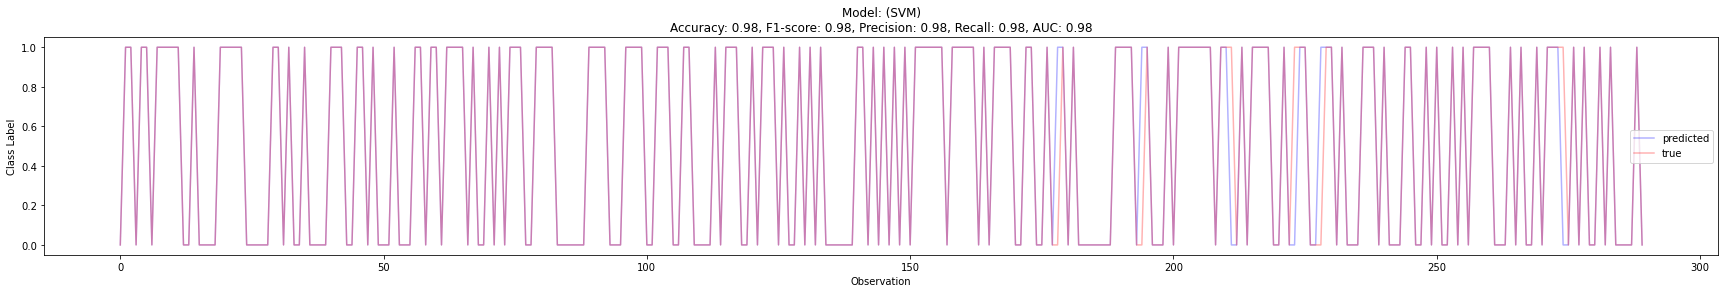

predicting SVM ...
done


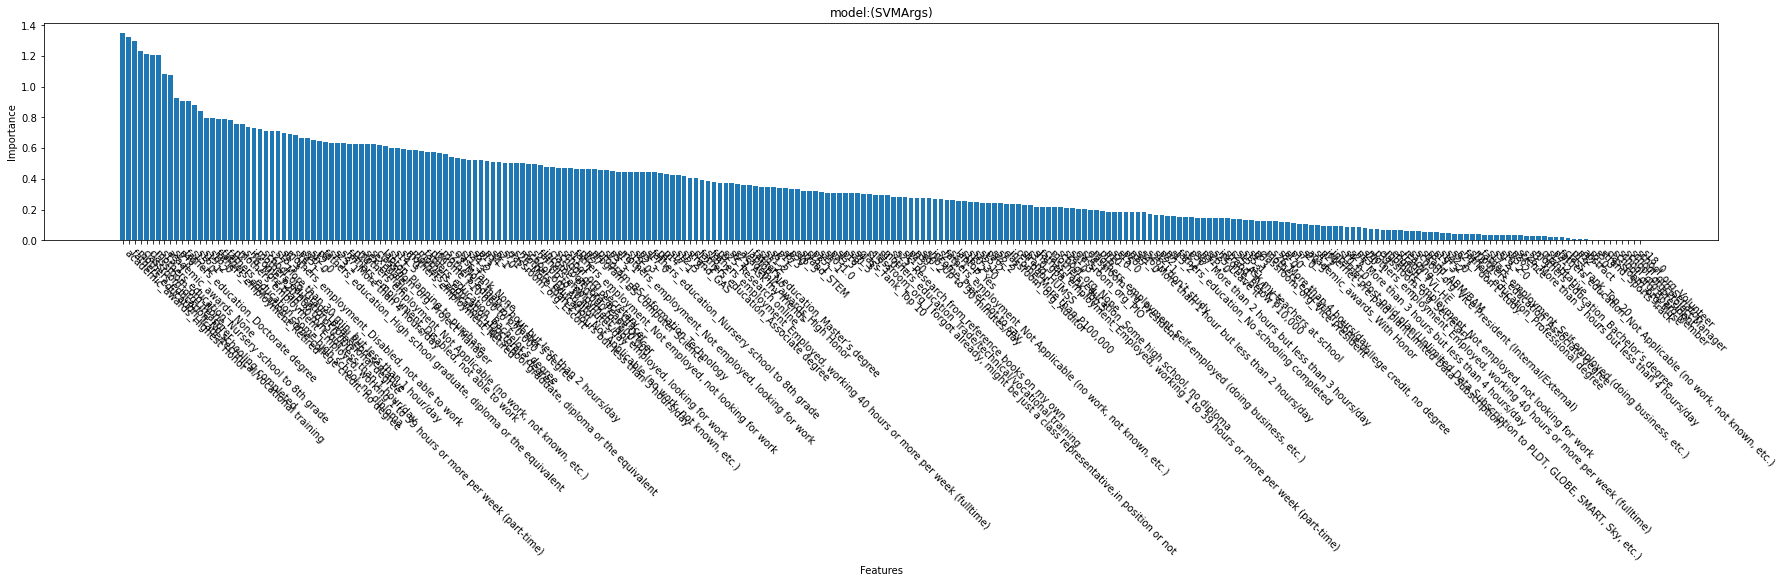

{'academic_awards_Highest Honor': 1.3481112193536506,
 'fathers_education_Trade/technical/vocational training': 1.320718513314201,
 'mothers_education_No schooling completed': 1.2966137263436721,
 'classroom_org_Treasurer': 1.232974958748148,
 'classroom_org_None': 1.2096990757133628,
 'mothers_education_Nursery school to 8th grade': 1.2054528545192564,
 's13_1': 1.203065804471618,
 'academic_awards_None': 1.0842740293791557,
 's2_3': 1.0778358581290228,
 'p40': 0.9257498627890763,
 'fathers_education_Doctorate degree': 0.9076174985757482,
 's13_0': 0.9042683193071475,
 's16_1': 0.8796873120649907,
 's19_2': 0.8438518162733315,
 's16_0': 0.7992069899805897,
 'fathers_employment_Retired': 0.7952484547476182,
 'fathers_education_Some college credit, no degree': 0.7904001853587808,
 'fathers_education_Some high school, no diploma': 0.7888081760204065,
 'p2': 0.78075463689276,
 'mothers_employment_Employed, working 1 to 39 hours or more per week (part-time)': 0.7584177548171862,
 's26_More

In [17]:
model = Models(Args.modelArgs)

model.train(dfTrain.loc[:, dfTrain.columns != 'success'],
            dfTrain["success"])    

model.evaluate(dfTrain.loc[:, dfTrain.columns != 'success'],
               dfTrain["success"])

preds = model.predict(dfTest.loc[:, dfTrain.columns != 'success'])

model.interpret()